In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
import nltk
import gensim
import gensim.downloader as gensim_api

import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\karth\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#loading the train and the test data
train = pd.read_csv("C:/Users/karth/Desktop/Dissertation/Data/AG_news_train.csv")
test = pd.read_csv("C:/Users/karth/Desktop/Dissertation/Data/AG_news_test.csv")
frames = [train,test]
data = pd.concat(frames)
data

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [4]:
data['Class Index'] = data['Class Index'].astype('str')
classes = {"1" : "World",
                     "2" : "Sports",
                     "3" : "Business",
                     "4" : "Sci&Tech"}

data['Class'] = data['Class Index'].map(classes)
data

,Class Index,Title,Description,Class
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business
...,...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,World
7596,2,Void is filled with Clement,With the supply of attractive pitching options...,Sports
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,Sports
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,Business


In [5]:
def text_preprocessing(text, flag_stemm=False, flag_lemma=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    #remove numbers from text
    text = re.sub("\d+", "", text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flag_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flag_lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

In [6]:
##applying the text preprocessing function created to the entire dataset
data["cleaned_text"] = data["Description"].apply(lambda x: text_preprocessing(x, flag_stemm=False, flag_lemma=True, lst_stopwords=lst_stopwords))
data.head()

,Class Index,Title,Description,Class,cleaned_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,reuters shortsellers wall street dwindlingband...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business,reuters private investment firm carlyle groupw...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business,reuters soaring crude price plus worriesabout ...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Business,reuters authority halted oil exportflows main ...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",Business,afp tearaway world oil price toppling record s...


In [7]:
data_sample = data.groupby('Class').apply(lambda x: x.sample(n=500)).reset_index(drop = True)
data_sample['Class'].value_counts()

Business    500
Sports      500
Sci&Tech    500
World       500
Name: Class, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_sample['cleaned_text'], data_sample['Class Index'], test_size=0.25, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [10]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [11]:
import tensorflow_hub as hub
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using C:\Users\karth\AppData\Local\Temp\tfhub_modules to cache modules.


In [12]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [13]:
def build_model(bert_layer, max_len=128):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
import keras
import keras.utils
from keras import utils as np_utils


In [15]:
max_len = 128
train_input = bert_encode(X_train, tokenizer, max_len=max_len)
val_input = bert_encode(X_val, tokenizer, max_len=max_len)
test_input = bert_encode(X_test, tokenizer, max_len=max_len)
train_labels = keras.utils.np_utils.to_categorical(y_train, num_classes=5)
val_labels = keras.utils.np_utils.to_categorical(y_val, num_classes=5)

In [16]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

C:\Users\karth\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('weights_BERT_sentece.hdf5', monitor='val_acc', verbose=1, save_best_only=False, mode='auto')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

In [18]:

history = model.fit(
    train_input, train_labels, 
    validation_data=(val_input,val_labels),
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=64,
    verbose=1)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 1.4551 - accuracy: 0.3387  
Epoch 00001: saving model to weights_BERT_sentece.hdf5
18/18 [==============================] - 2787s 151s/step - loss: 1.4551 - accuracy: 0.3387 - val_loss: 1.0589 - val_accuracy: 0.7147
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 1.0072 - accuracy: 0.6124  
Epoch 00002: saving model to weights_BERT_sentece.hdf5
18/18 [==============================] - 2627s 146s/step - loss: 1.0072 - accuracy: 0.6124 - val_loss: 0.5713 - val_accuracy: 0.8480
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.7529  
Epoch 00003: saving model to weights_BERT_sentece.hdf5
18/18 [==============================] - 2656s 148s/step - loss: 0.6919 - accuracy: 0.7529 - val_loss: 0.4001 - val_accuracy: 0.8747
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.8427  
Epoch 00004: saving model to weights_BERT_sentece.hd

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

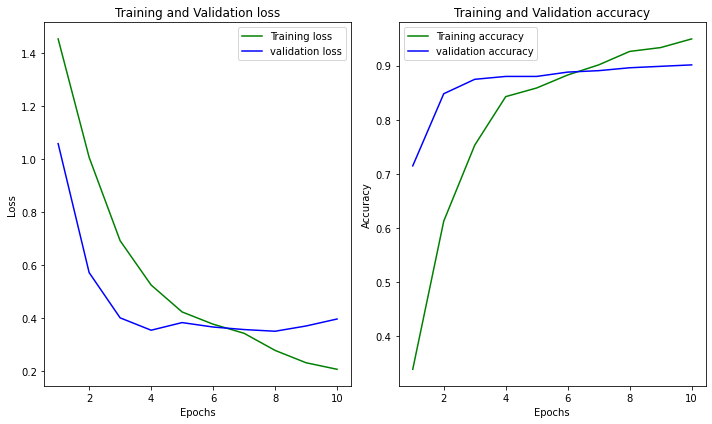

In [20]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = []
for x in range(1,11):
    epochs.append(x)
    
fig, (axes1, axes2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes1.plot(epochs, loss_train, 'g', label='Training loss')
axes1.plot(epochs, loss_val, 'b', label='validation loss')
axes1.title.set_text('Training and Validation loss')
axes1.set_xlabel('Epochs')
axes1.set_ylabel('Loss')
axes1.legend()

axes2.plot(epochs, acc_train, 'g', label='Training accuracy')
axes2.plot(epochs, acc_val, 'b', label='validation accuracy')
axes2.title.set_text('Training and Validation accuracy')
axes2.set_xlabel('Epochs')
axes2.set_ylabel('Accuracy')
axes2.legend()
fig.tight_layout()

              precision    recall  f1-score   support

    Business       0.88      0.84      0.86       130
     Sci&Tec       0.93      0.98      0.96       113
      Sports       0.84      0.88      0.86       136
       World       0.87      0.82      0.84       121

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500



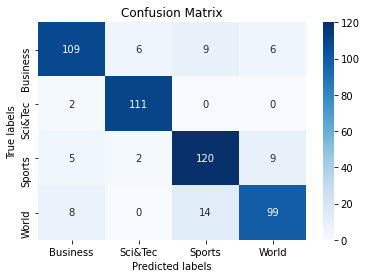

In [21]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt   
y_pred_ohe = model.predict(test_input)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
target_names = ["Business","Sci&Tec","Sports","World"]
confusion_matrix = metrics.confusion_matrix(y_true=y_test.astype(str), y_pred=y_pred_labels.astype(str))  # shape=(12, 12)

ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt="d",cmap='Blues',ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(target_names); ax.yaxis.set_ticklabels(target_names);

print(classification_report(y_true=y_test.astype(str), y_pred=y_pred_labels.astype(str), target_names=target_names))